# T2D multi-omics causal analysis
This tutorial applies **CauTrigger** to single-cell multi-omics data from pancreatic islets of 
healthy, pre-diabetic, and T2D individuals. The analysis models hierarchical transcriptional 
regulation from **transcription factors (TFs) → cis-regulatory elements (CREs) → target genes (TGs) → T2D state**.

Steps include:
1. Identifying T2D-related TGs from scRNA-seq data.  
2. Inferring upstream CRE–TG relationships using scATAC-seq data.  
3. Integrating TF–CRE–TG modules to reveal causal transcriptional hierarchies.  
4. Performing in silico activation of key TFs (e.g., *FOS*, *JUN*) to assess potential regulatory recovery effects.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import normalize, minmax_scale
from scipy.stats import pearsonr, spearmanr, f_oneway, norm
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import scanpy as sc
import torch
import torch.nn as nn
# torch.cuda.set_device(1)
# import pybedtools
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from scipy.sparse import load_npz
from scipy.sparse import coo_matrix
from scipy.io import mmread

from cautrigger.utils import set_seed, pert_plot_vector_field
from cautrigger.model import CauTrigger3L, CauTrigger2L, CauTrigger1L
set_seed(42)

In [2]:
data_dir = os.path.join("..", "data/")
output_dir = os.path.join("..", "output/")
os.makedirs(output_dir, exist_ok=True)

In [3]:
TF = pd.read_csv(os.path.join(data_dir, 'filtered_TF_pseudobulk.csv'), index_col=0).T
RE = pd.read_csv(os.path.join(data_dir, 'filtered_RE_pseudobulk.csv'), index_col=0).T
TG = pd.read_csv(os.path.join(data_dir, 'filtered_TG_pseudobulk.csv'), index_col=0).T

In [4]:
# TG--RE interaction matrix
sparse_matrix = load_npz(os.path.join(data_dir, "TG_RE_interaction_matrix.npz"))
sparse_matrix_index = pd.read_csv(os.path.join(data_dir, "TG_RE_interaction_matrix_rows.txt")).values.flatten()
sparse_matrix_column = pd.read_csv(os.path.join(data_dir, "TG_RE_interaction_matrix_cols.txt")).values.flatten()

In [5]:
t2d_samples = ["C0019", "C0024", "C0021", "A0024", "A0031", "C0023"]
pre_samples = ["A0011", "A0028", "A0029", "C0013", "C0014", "A0030", "A0021", "C0022"]
control_samples = ["C0026", "C0027", "A0019", "A0033", "A0027", "C0025"]

barcodes = pd.read_csv(data_dir + 'beta_RNA.barcodes', header=None)
barcodes[['sample_id', 'cell_barcode']] = barcodes[0].str.split('_', expand=True)
barcodes['state'] = [
    'control' if a in control_samples else
    'pre' if a in pre_samples else
    't2d' for a in barcodes['sample_id']
]
barcodes = barcodes.set_index(0)
filtered_barcodes = barcodes.loc[TF.index]

aligned_values = filtered_barcodes.state.values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_values = label_encoder.fit_transform(aligned_values)

label_map = pd.DataFrame({
    "celltype": label_encoder.classes_,
    "label": np.arange(len(label_encoder.classes_))
})
celltypes = label_encoder.classes_

In [6]:
set_seed(42)

## run CauTrigger

In [7]:
adata1 = sc.AnnData(X=np.array(TG))
adata1.var_names = np.array(TG.columns)
adata1.obs_names = np.array(TG.index)
adata1.obs["labels"] = numeric_values
adata1.obs["celltype"] = aligned_values

model321_1 = CauTrigger1L(
    adata1,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
)
model321_1.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [03:31<00:00,  1.42it/s]


In [8]:
weight_df_weight1 = model321_1.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer1_indices = np.argsort(weight_df_weight1[0]['weight'])[-1000:][::-1]

adata2 = sc.AnnData(RE)
adata2.var_names = np.array(RE.columns)
adata2.obs_names = np.array(RE.index)
adata2.obs["labels"] = numeric_values
adata2.obs["celltype"] = aligned_values
adata2.obsm['X_down'] = adata1.X[:, causal_factors_layer1_indices]
adata2.uns['TG_names'] = adata1[:, causal_factors_layer1_indices].var_names.values

In [9]:
model321_2 = CauTrigger2L(
    adata2,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
)

model321_2.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [06:56<00:00,  1.39s/it]


In [10]:
weight_df_weight2 = model321_2.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer2_indices = np.argsort(weight_df_weight2[0]['weight'])[-5000:][::-1]

adata3 = sc.AnnData(TF)
adata3.var_names = np.array(TF.columns)
adata3.obs_names = np.array(TF.index)
adata3.obs["labels"] = numeric_values
adata3.obs["celltype"] = aligned_values
adata3.obsm['X_down2'] = adata2.obsm['X_down'].copy()
adata3.obsm['X_down1'] = adata2.X[:, causal_factors_layer2_indices]
adata3.uns['TG_names'] = adata2.uns['TG_names'].copy()
adata3.uns['RE_names'] = adata2[:, causal_factors_layer2_indices].var_names.values

In [11]:
model321_3 = CauTrigger3L(
    adata3,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
    decoder_down2_sparse=False,
)

In [12]:
model321_3.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|█████████████████████████████████████████████████████████████████████| 300/300 [1:22:23<00:00, 16.48s/it]


In [13]:
adata_tg = sc.AnnData(X=np.array(pd.concat([TF,RE,TG], axis=1)))
adata_tg.obs["celltype"] = aligned_values

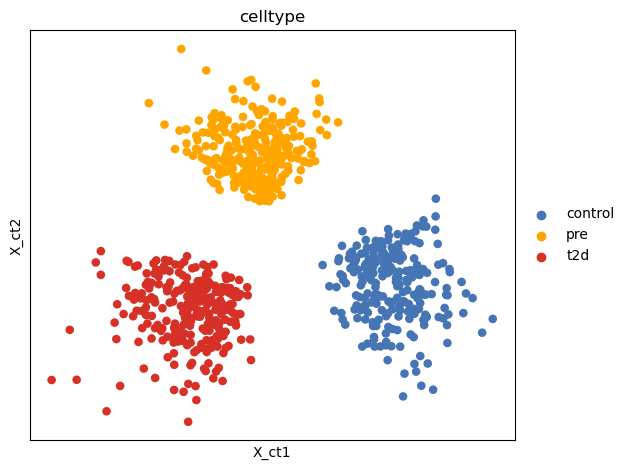

In [14]:
adata_tg.obsm['X_ct'] = model321_3.get_model_output()['latent'][:, :2][:, [1, 0]]
sc.pl.embedding(adata_tg, basis='X_ct', color='celltype', show=False, palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'})
plt.tight_layout()
plt.savefig(output_dir + 'tg_Z.pdf')

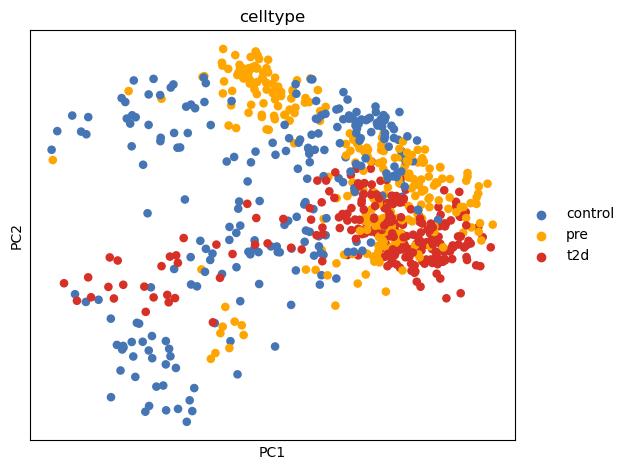

In [15]:
# PCA
sc.tl.pca(adata_tg)
sc.pl.pca(adata_tg, color='celltype', show=False, palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'})
plt.tight_layout()
# plt.savefig(output_dir + 'tg_PCA.pdf')

In [16]:
adata_TF = adata3.copy()
adata_down = sc.AnnData(adata3.obsm['X_down2'])
adata_down.var_names = adata3.uns['TG_names']
adata_down.obs_names = TG.index.values
adata_down.obs = adata_TF.obs.copy()
adata_down.obsm['X_ct'] = model321_3.get_model_output()['latent'][:, :2][:, [1, 0]]

In [17]:
dot_size = None
pert_Gene = ['FOS', 'JUN']
fold = [20, 20]

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


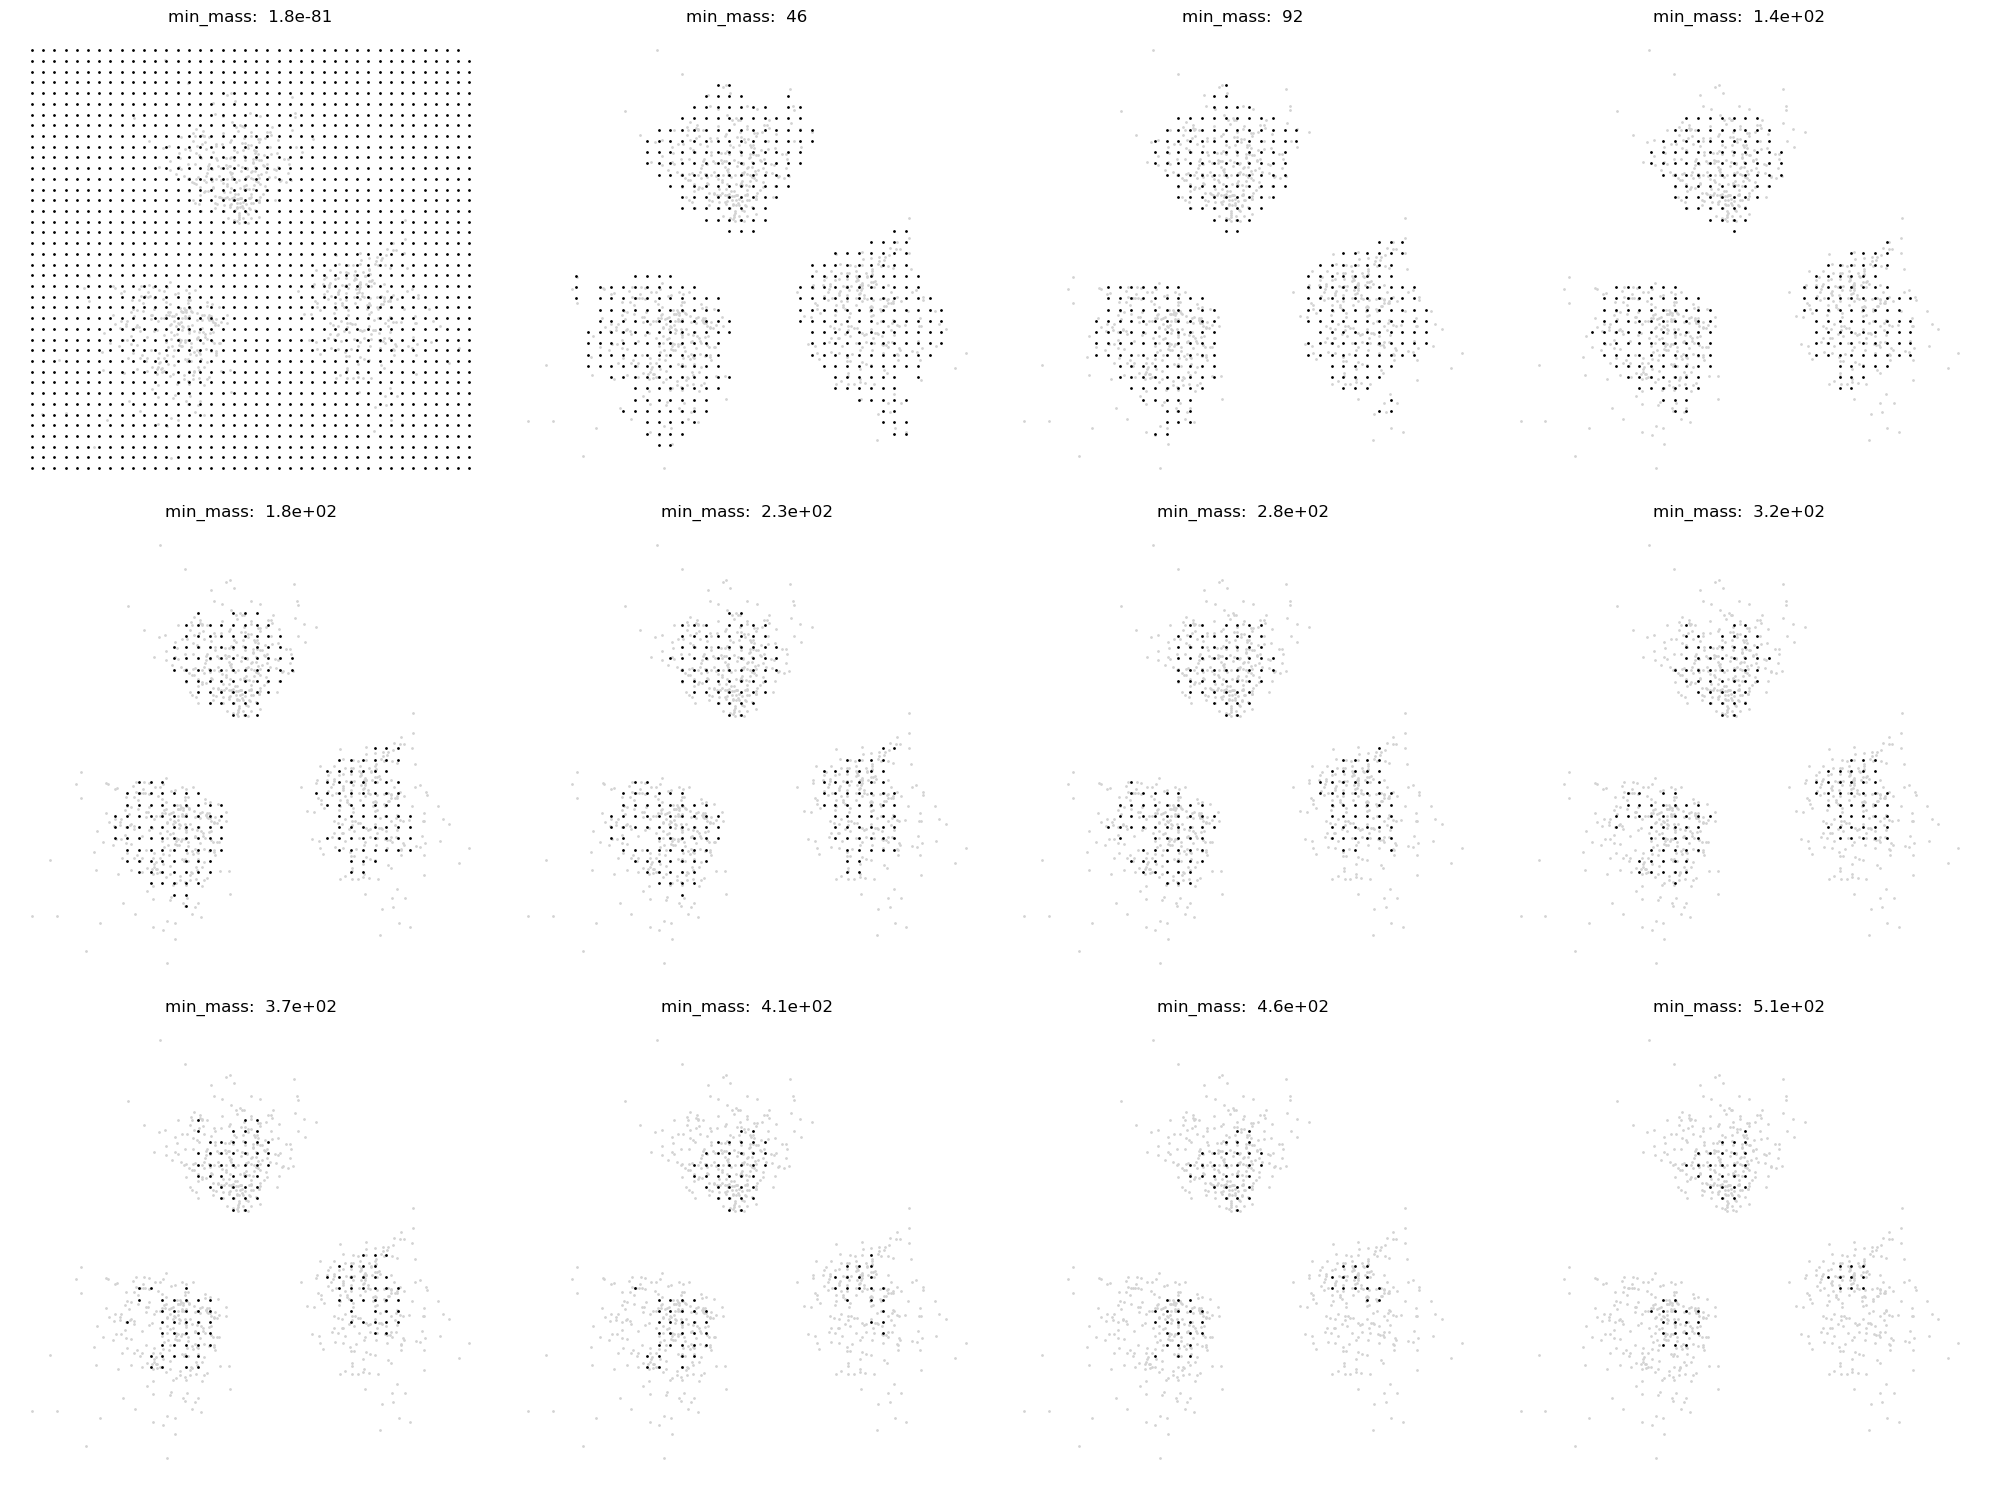

{'latent': array([[0.35976222, 0.60128593, 0.9952867 , ..., 0.6821408 , 0.43624187,
         0.74404114],
        [0.36014   , 0.65534127, 1.0023377 , ..., 0.6937659 , 0.44885802,
         0.79042304],
        [0.39414886, 0.6574092 , 0.9953942 , ..., 0.6631692 , 0.47129157,
         0.7673505 ],
        ...,
        [0.37424102, 0.8259491 , 0.9844584 , ..., 0.6721867 , 0.43968883,
         0.7678825 ],
        [0.37770766, 0.8230328 , 0.9231202 , ..., 0.6475022 , 0.42355025,
         0.72056276],
        [0.42914638, 0.81321156, 0.96441627, ..., 0.65043944, 0.43554533,
         0.75407183]], dtype=float32),
 'logits': array([[-0.33242223,  0.5190135 , -0.75700474],
        [-0.3014224 ,  0.50748223, -0.7830999 ],
        [-0.3059253 ,  0.5159052 , -0.791774  ],
        ...,
        [-0.2359322 ,  0.4852621 , -0.84146655],
        [-0.237067  ,  0.48637223, -0.841771  ],
        [-0.24069667,  0.49775538, -0.8577024 ]], dtype=float32),
 'probs': array([[0.25018442, 0.58618426, 0.163631

In [33]:
pert_plot_vector_field(
    adata_TF=adata_TF,
    adata_down=adata_down,
    model=model321_3,
    pert_Gene=pert_Gene,
    pert_celltype=['t2d'],         # perturbation applied to T2D samples
    fold=fold,
    state_obs='celltype',
    n_neighbors=None,
    scale=30,
    run_suggest_mass_thresholds=True,
    dot_size=dot_size,
    min_mass=1.3,
    embedding_name='X_ct'
)

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


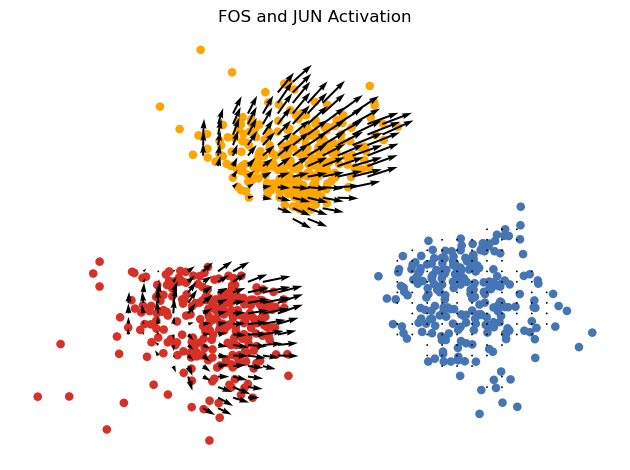

In [34]:
model_output_pert = pert_plot_vector_field(
    adata_TF=adata_TF,
    adata_down=adata_down,
    model=model321_3,
    pert_Gene=pert_Gene,
    pert_celltype=['t2d', 'pre'],      # apply perturbation to T2D + Pre-T2D groups
    fold=fold,
    state_obs='celltype',
    n_neighbors=None,
    scale=30,
    run_suggest_mass_thresholds=False,
    dot_size=None,
    min_mass=92,                       # threshold for vector field mass
    embedding_name='X_ct',
    palette={"control": "#4575B4", "pre": "orange", "t2d": "#D73027"},
    save_dir=output_dir,
    direction='Activation'
)


In [20]:
tftg_score = model321_3.get_3to1_ig(celltype='t2d')
tftg_score = tftg_score.mean(0)
tftg_score_df = pd.DataFrame(tftg_score, index=TF.columns.values, columns=adata3.uns['TG_names'])

In [21]:
tftg_score_df.loc['FOS', tftg_score_df.loc['FOS'].abs().sort_values(ascending=False).index][:10].index.values

array(['HS6ST3', 'G6PC2', 'TTR', 'PAPSS2', 'H3F3B', 'MT1E', 'LRRTM3',
       'FGF14', 'PPM1E', 'ELAVL4'], dtype=object)

In [22]:
tftg_score_df.loc['JUN', tftg_score_df.loc['JUN'].abs().sort_values(ascending=False).index][:10].index.values

array(['SLC30A8', 'CPNE4', 'EGFEM1P', 'SOX5', 'FGF14', 'ESRRG', 'RYR2',
       'RASGRF2', 'ELAVL4', 'NAV2'], dtype=object)

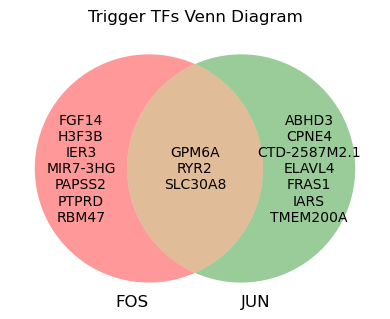

In [23]:
from matplotlib_venn import venn2_unweighted

fos = set(['PAPSS2', 'GPM6A', 'MIR7-3HG', 'FGF14', 'SLC30A8', 'RBM47',
       'H3F3B', 'PTPRD', 'RYR2', 'IER3'])
jun = set(['SLC30A8', 'GPM6A', 'RYR2', 'CTD-2587M2.1', 'ELAVL4', 'ABHD3',
       'IARS', 'FRAS1', 'CPNE4', 'TMEM200A'])


plt.figure(figsize=(4, 4))
v = venn2_unweighted([fos, jun], set_labels=('FOS', 'JUN'))

regions = {
    '10': fos - jun,
    '01': jun - fos,
    '11': fos & jun
}

for region_id, genes in regions.items():
    label = v.get_label_by_id(region_id)
    if label:
        gene_text = '\n'.join(sorted(genes)) if genes else ''
        label.set_text(gene_text)

plt.title("Trigger TFs Venn Diagram")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'TG_venn.pdf'))
plt.show()

## draw expression violin plot

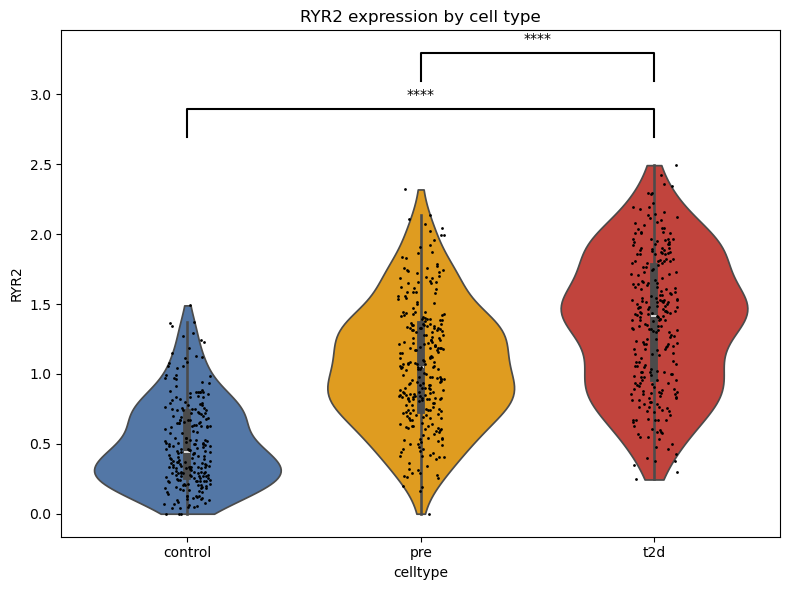

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


gene = 'RYR2'
expr = adata_down[:, gene].X.toarray().flatten()
celltype = adata_down.obs['celltype'].values

df = pd.DataFrame({f'{gene}': expr, 'celltype': celltype})

plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df, x='celltype', y=gene, inner='box', cut=0, palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'})
sns.stripplot(data=df, x='celltype', y=gene, color='k', size=2, jitter=True)

group1 = df[df['celltype'] == 'control'][gene]
group2 = df[df['celltype'] == 'pre'][gene]
group3 = df[df['celltype'] == 't2d'][gene]

def get_significance(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

_, pval_13 = ttest_ind(group1, group3, equal_var=False)
_, pval_23 = ttest_ind(group2, group3, equal_var=False)
sig_13 = get_significance(pval_13)
sig_23 = get_significance(pval_23)

y_max = df[gene].max()
h = 0.2
col = 'k'

# 1 vs 3
x1, x3 = 0, 2
plt.plot([x1, x1, x3, x3], [y_max+0.2, y_max+0.4, y_max+0.4, y_max+0.2], lw=1.5, c=col)
plt.text((x1+x3)*.5, y_max+0.45, sig_13, ha='center', va='bottom', color=col)

# 2 vs 3
x2 = 1
plt.plot([x2, x2, x3, x3], [y_max+0.6, y_max+0.8, y_max+0.8, y_max+0.6], lw=1.5, c=col)
plt.text((x2+x3)*.5, y_max+0.85, sig_23, ha='center', va='bottom', color=col)

plt.title(f"{gene} expression by cell type")
plt.tight_layout()
plt.savefig(output_dir + f'{gene}_violin.pdf')
plt.show()


## Fetch CRE-TG pairs and draw arc plot in R using 'cicero'

In [25]:
row = sparse_matrix.toarray()[np.where(sparse_matrix_index == 'SLC30A8')[0][0], :]
nonzero_indices = np.where(row != 0)[0]

In [26]:
sparse_matrix_column[nonzero_indices]

array(['8:117745068-117745568', '8:117962120-117962620'], dtype=object)

In [27]:
np.isin(sparse_matrix_column[nonzero_indices], adata3.uns['RE_names'])

array([ True, False])

In [28]:
geneanno = pd.read_csv(os.path.join(data_dir, 'hg19_geneanno.txt'), sep='\t')
geneanno = geneanno.drop_duplicates(subset=['Gene name'])
geneanno.loc[geneanno['Gene name'] == 'SLC30A8', :]

,Gene stable ID,Transcript stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Transcription start site (TSS)
170716,ENSG00000164756,ENST00000521243,8,117962512,118188953,1,SLC30A8,117962512


In [29]:
## code in R

# library(cicero)
# gene_annotation_sample1 <- data.frame(
#   chromosome = "chr8",
#   start = 117962512	,
#   end = 118188953,
#   strand = "+",
#   symbol = 'SLC30A8',
#   transcript = 'ENSG00000164756'
# )

# conns_df <- data.frame(
#   Peak1 = c('chr8_117745068_117745568', 'chr8_117962120_117962620'),
#   Peak2 = c('chr8_117962512_117962512', 'chr8_117962512_117962512'),
#   coaccess = c(1,1),
#   conn_color = c("green","green")
# )

# pdf("D:/CauTrigger_Project/CauTrigger-new/BenchmarkGRN/output/t2d/arc_plot_SLC30A8.pdf", width = 4, height = 3)
# plot_connections(conns_df, "chr8", 117962512-250000, 117962512+250000, 
#                  gene_model = gene_annotation_sample1, 
#                  peak_color = "conn_color",
#                  connection_color = "conn_color",
#                  connection_width = 1,
#                  gene_model_color = "#81D2C7",
#                  # viewpoint = "chr5_115910629_115910630",
#                  collapseTranscripts = "longest" )
# dev.off()